In [1]:
# Cell 1 完整代码
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# GPU配置
print("="*40 + " GPU配置 " + "="*40)
gpu_devices = tf.config.list_physical_devices('GPU')
print(f"检测到GPU数量: {len(gpu_devices)}")

# 配置GPU内存动态增长
if gpu_devices:
    try:
        for gpu in gpu_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        # 启用混合精度训练
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("已启用混合精度训练")
    except RuntimeError as e:
        print(e)
else:
    print("警告：未检测到可用GPU，将使用CPU运行")

# 设置工作路径
print("\n" + "="*40 + " 路径配置 " + "="*40)
base_path = '/root/autodl-tmp/pro/'
os.chdir(base_path)
print(f"当前工作目录: {os.getcwd()}")

# 完整目录检查
print("\n" + "="*40 + " 目录检查 " + "="*40)
required_dirs = [
    'smoke2/Training/smoke',#frame2改名smoke2
    'smoke2/Training/no_smoke',
    'smoke2/Validation/smoke', 
    'smoke2/Validation/no_smoke',
    'smoke2/Test/smoke',
    'smoke2/Test/no_smoke'
]

missing_dirs = []
for d in required_dirs:
    full_path = os.path.join(base_path, d)
    if not os.path.exists(full_path):
        missing_dirs.append(full_path)
        print(f"× 缺失目录: {full_path}")
    else:
        print(f"√ 存在目录: {full_path}")

if missing_dirs:
    print("\n警告：缺失关键目录，请检查数据集路径！")
else:
    print("\n所有目录检查通过")


======================================== GPU配置 ========================================
检测到GPU数量: 1
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6
已启用混合精度训练

======================================== 路径配置 ========================================
当前工作目录: /root/autodl-tmp/pro

======================================== 目录检查 ========================================
√ 存在目录: /root/autodl-tmp/pro/frames2/Training/smoke
√ 存在目录: /root/autodl-tmp/pro/frames2/Training/no_smoke
√ 存在目录: /root/autodl-tmp/pro/frames2/Validation/smoke
√ 存在目录: /root/autodl-tmp/pro/frames2/Validation/no_smoke
√ 存在目录: /root/autodl-tmp/pro/frames2/Test/smoke
√ 存在目录: /root/autodl-tmp/pro/frames2/Test/no_smoke

所有目录检查通过


In [2]:
# Cell 2完整代码（包含test_generator定义）
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# 图像参数
img_width, img_height = 128, 128
batch_size = 32

# 训练数据生成器（带增强）
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    channel_shift_range=100,
    fill_mode='constant',
    preprocessing_function=lambda x: x * (1 + np.random.uniform(-0.1, 0.1))
)

# 验证和测试数据生成器
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 训练数据流
train_generator = train_datagen.flow_from_directory(
    'smoke2/Training',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes=['no_smoke', 'smoke'],
    seed=42
)

# 验证数据流
val_generator = val_datagen.flow_from_directory(
    'smoke2/Validation',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes=['no_smoke', 'smoke'],
    shuffle=False
)

# 测试数据流（必须定义）
test_generator = test_datagen.flow_from_directory(
    'smoke2/Test',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes=['no_smoke', 'smoke'],
    shuffle=False  # 测试集必须保持顺序
)

# 类别权重计算
no_smoke_count = sum(train_generator.classes == 0)
smoke_count = sum(train_generator.classes == 1)
total = no_smoke_count + smoke_count
weight_for_0 = (1 / no_smoke_count) * (total / 2.0)
weight_for_1 = (1 / smoke_count) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"\n测试集样本数: {test_generator.samples}")
print(f"类别权重: {class_weight}")


Found 1492 images belonging to 2 classes.
Found 187 images belonging to 2 classes.
Found 187 images belonging to 2 classes.

测试集样本数: 187
类别权重: {0: 0.9527458492975734, 1: 1.0521861777150916}


In [3]:
# Cell 3 完整代码
"""
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import Loss
import tensorflow as tf

class FocalLoss(Loss):
    def __init__(self, gamma=2.0, alpha=0.75, name="focal_loss"):
        super().__init__(name=name)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        p_t = tf.where(tf.equal(y_true, 1.0), y_pred, 1 - y_pred)
        alpha_factor = tf.where(tf.equal(y_true, 1.0), self.alpha, 1 - self.alpha)
        
        loss = -alpha_factor * tf.pow(1. - p_t, self.gamma) * tf.math.log(p_t)
        return tf.reduce_mean(loss)

def build_attention_model(input_shape=(128, 128, 3)):
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs)
    x = tf.cast(x, tf.float32)  # 显式类型转换
    
    # 通道注意力
    channel_att = layers.GlobalAveragePooling2D()(x)
    channel_att = layers.Dense(x.shape[-1]//8, activation='relu')(channel_att)
    channel_att = layers.Dense(x.shape[-1], activation='sigmoid')(channel_att)
    x = layers.Multiply()([x, channel_att])
    
    # 空间注意力
    spatial_att = layers.Conv2D(1, (1,1), activation='sigmoid')(x)
    x = layers.Multiply()([x, spatial_att])
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.6)(x)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)
    
    return Model(inputs, outputs)

model = build_attention_model()
model.summary()
"""
# Cell 3 完整代码（修改后的）

from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import Loss
import tensorflow as tf

# 定义 FocalLoss 类，支持 reduction 参数
class FocalLoss(Loss):
    def __init__(self, gamma=2.0, alpha=0.75, reduction=tf.keras.losses.Reduction.AUTO, name="focal_loss"):
        super().__init__(name=name, reduction=reduction)  # 确保传递 reduction 参数给父类
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        p_t = tf.where(tf.equal(y_true, 1.0), y_pred, 1 - y_pred)
        alpha_factor = tf.where(tf.equal(y_true, 1.0), self.alpha, 1 - self.alpha)
        
        loss = -alpha_factor * tf.pow(1. - p_t, self.gamma) * tf.math.log(p_t)
        return tf.reduce_mean(loss)

# 构建带有注意力机制的卷积神经网络
def build_attention_model(input_shape=(128, 128, 3)):
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs)
    x = tf.cast(x, tf.float32)  # 显式类型转换
    
    # 通道注意力
    channel_att = layers.GlobalAveragePooling2D()(x)
    channel_att = layers.Dense(x.shape[-1]//8, activation='relu')(channel_att)
    channel_att = layers.Dense(x.shape[-1], activation='sigmoid')(channel_att)
    x = layers.Multiply()([x, channel_att])
    
    # 空间注意力
    spatial_att = layers.Conv2D(1, (1,1), activation='sigmoid')(x)
    x = layers.Multiply()([x, spatial_att])
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.6)(x)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)
    
    return Model(inputs, outputs)

# 构建并查看模型架构
model = build_attention_model()
model.summary()



2025-06-18 15:34:45.807972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-18 15:34:46.468101: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22182 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:e1:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 4, 4, 2048)   23587712    ['input_2[0][0]']                
                                                                                                  
 tf.cast (TFOpLambda)           (None, 4, 4, 2048)   0           ['resnet50[0][0]']               
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['tf.cast[0][0]']            

In [4]:
# Cell 4 完整代码
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 完整回调配置
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=8,
        min_delta=0.001,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=4,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='auto',
        save_freq='epoch',
        verbose=1
    )
]

# 完整第一阶段训练
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-3,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name='Adam'
    ),
    loss=FocalLoss(gamma=2, alpha=0.75),
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=2
)

# 完整第二阶段微调
model.get_layer('resnet50').trainable = True
for layer in model.get_layer('resnet50').layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-5,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name='Adam'
    ),
    loss=FocalLoss(gamma=2, alpha=0.75),
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    epochs=10,
    initial_epoch=history.epoch[-1],
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=2
)


Epoch 1/20


2025-06-18 15:34:52.784231: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2025-06-18 15:34:54.171063: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.



Epoch 1: val_loss improved from inf to 0.06556, saving model to best_model.h5
46/46 - 30s - loss: 0.0733 - accuracy: 0.4719 - val_loss: 0.0656 - val_accuracy: 0.4313 - lr: 0.0010 - 30s/epoch - 652ms/step
Epoch 2/20

Epoch 2: val_loss improved from 0.06556 to 0.04373, saving model to best_model.h5
46/46 - 25s - loss: 0.0676 - accuracy: 0.5034 - val_loss: 0.0437 - val_accuracy: 1.0000 - lr: 0.0010 - 25s/epoch - 550ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.04373 to 0.02896, saving model to best_model.h5
46/46 - 26s - loss: 0.0624 - accuracy: 0.5870 - val_loss: 0.0290 - val_accuracy: 1.0000 - lr: 0.0010 - 26s/epoch - 564ms/step
Epoch 4/20

Epoch 4: val_loss did not improve from 0.02896
46/46 - 25s - loss: 0.0619 - accuracy: 0.6034 - val_loss: 0.0327 - val_accuracy: 1.0000 - lr: 0.0010 - 25s/epoch - 554ms/step
Epoch 5/20

Epoch 5: val_loss improved from 0.02896 to 0.02313, saving model to best_model.h5
46/46 - 26s - loss: 0.0580 - accuracy: 0.6365 - val_loss: 0.0231 - val_accur

In [5]:
# Cell 5完整代码（最终可运行版）
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import os
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# 作用域验证
assert 'test_generator' in globals(), "必须先运行Cell 2初始化test_generator"
assert 'model' in globals(), "必须先运行Cell 3和Cell 4完成模型训练"

# 重置生成器
test_generator.reset()

# 获取真实标签
y_true = test_generator.classes

# 完整预测
y_pred_probs = model.predict(
    test_generator,
    steps=np.ceil(test_generator.samples / test_generator.batch_size),
    verbose=1
).flatten()

# 阈值优化
precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n最优分类阈值: {best_threshold:.3f}")
y_pred = (y_pred_probs > best_threshold).astype(int)

# 分类报告
class_labels = list(test_generator.class_indices.keys())
print("\n分类报告:")
print(classification_report(
    y_true, 
    y_pred, 
    target_names=class_labels,
    digits=4
))

# 混淆矩阵
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, 
           annot=True, 
           fmt='d', 
           cmap='Blues',
           xticklabels=class_labels,
           yticklabels=class_labels,
           annot_kws={'size': 16})
plt.xlabel('预测标签', fontsize=14)
plt.ylabel('真实标签', fontsize=14)
plt.title('混淆矩阵', fontsize=16)
plt.show()

# PR曲线
plt.figure(figsize=(12, 8))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.plot(thresholds, f1_scores[:-1], "r-", label="F1 Score", linewidth=2)
plt.axvline(x=best_threshold, color='k', linestyle='--', linewidth=2)
plt.xlabel("阈值", fontsize=14)
plt.ylabel("分数", fontsize=14)
plt.title("Precision-Recall曲线", fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.show()

# 模型保存
model.save('smoke_detection_final_model.h5')
np.save('optimal_threshold.npy', best_threshold)
print("模型和阈值已保存到当前目录")
"""


'\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport cv2\nimport tensorflow as tf\nimport os\nfrom sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve\n\n# 作用域验证\nassert \'test_generator\' in globals(), "必须先运行Cell 2初始化test_generator"\nassert \'model\' in globals(), "必须先运行Cell 3和Cell 4完成模型训练"\n\n# 重置生成器\ntest_generator.reset()\n\n# 获取真实标签\ny_true = test_generator.classes\n\n# 完整预测\ny_pred_probs = model.predict(\n    test_generator,\n    steps=np.ceil(test_generator.samples / test_generator.batch_size),\n    verbose=1\n).flatten()\n\n# 阈值优化\nprecisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_probs)\nf1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)\nbest_idx = np.argmax(f1_scores)\nbest_threshold = thresholds[best_idx]\n\nprint(f"\n最优分类阈值: {best_threshold:.3f}")\ny_pred = (y_pred_probs > best_threshold).astype(int)\n\n# 分类报告\nclass_labels = list(test_generator.class_indices.keys(

6/6 [==============================] - 3s 464ms/step

最优分类阈值: 0.581

分类报告:
              precision    recall  f1-score   support

    no_smoke     0.9897    1.0000    0.9948        96
       smoke     1.0000    0.9890    0.9945        91

    accuracy                         0.9947       187
   macro avg     0.9948    0.9945    0.9946       187
weighted avg     0.9947    0.9947    0.9947       187



/root/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 28151 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 28102 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 30697 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 38453 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 39044 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 27979 mi

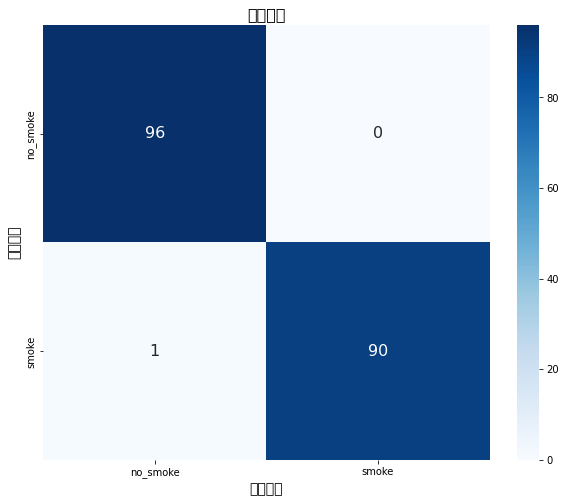

/root/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 26354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32447 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 38408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 20540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 20998 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 25968 mi

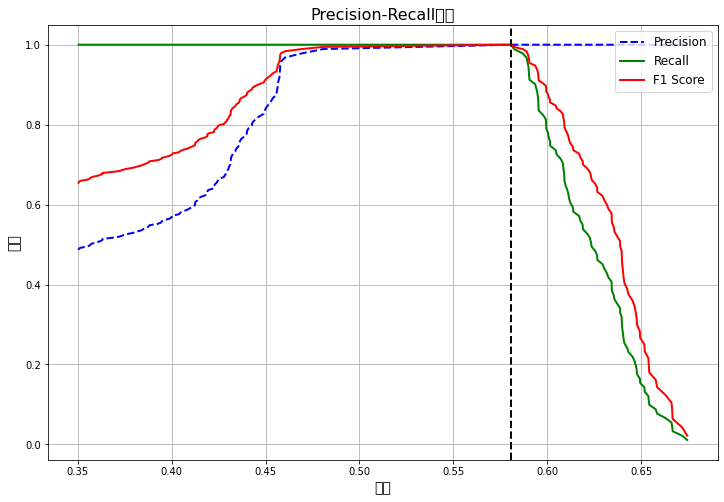

模型和阈值已保存到当前目录


In [6]:
"""
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# 加载预训练模型
model = load_model('best_model.h5')

# 加载和处理输入图像
img_path = 'frames2/Test/no_smoke/197.png'#frames2/Test/smoke/807.png
img = image.load_img(img_path, target_size=(224, 224))  # 调整图像大小与模型一致
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # 增加一个批次维度
img_array /= 255.0  # 如果模型使用了归一化

# 获取模型的最后一个卷积层
last_conv_layer = model.get_layer('conv_5')  # 更改为您的模型最后一层卷积层的名称

# 创建一个模型，将图像输入和卷积层的输出连接起来
grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])

# 获取模型输出和梯度
with tf.GradientTape() as tape:
    last_conv_layer_output, predictions = grad_model(img_array)
    class_id = np.argmax(predictions[0])  # 获取预测类别的索引
    loss = predictions[0][class_id]

# 计算梯度
grads = tape.gradient(loss, last_conv_layer_output)
pooled_grads = K.mean(grads, axis=(0, 1, 2))  # 平均池化

# 获取最后卷积层的输出
last_conv_layer_output = last_conv_layer_output[0]

# 乘以梯度权重，并对每个通道进行池化
heatmap = last_conv_layer_output @ pooled_grads.numpy()
heatmap = np.mean(heatmap, axis=-1)  # 对特征图的通道进行平均

# 对热图进行归一化
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# 可视化热图
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.show()

# 将热图叠加到原图上
img = np.array(image.load_img(img_path))
plt.imshow(img)
plt.imshow(heatmap, alpha=0.5, cmap='jet')  # 将热图叠加到原图
plt.show()
"""
# Cell 5 完整代码（修改后的）
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import os
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# 作用域验证
assert 'test_generator' in globals(), "必须先运行Cell 2初始化test_generator"
assert 'model' in globals(), "必须先运行Cell 3和Cell 4完成模型训练"

# 加载模型时传递自定义的 FocalLoss
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# 加载模型，并传递自定义损失函数
model = load_model('best_model.h5', custom_objects={'FocalLoss': FocalLoss})

# 重置生成器
test_generator.reset()

# 获取真实标签
y_true = test_generator.classes

# 完整预测
y_pred_probs = model.predict(
    test_generator,
    steps=np.ceil(test_generator.samples / test_generator.batch_size),
    verbose=1
).flatten()

# 阈值优化
precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n最优分类阈值: {best_threshold:.3f}")
y_pred = (y_pred_probs > best_threshold).astype(int)

# 分类报告
class_labels = list(test_generator.class_indices.keys())
print("\n分类报告:")
print(classification_report(
    y_true, 
    y_pred, 
    target_names=class_labels,
    digits=4
))

# 混淆矩阵
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, 
           annot=True, 
           fmt='d', 
           cmap='Blues',
           xticklabels=class_labels,
           yticklabels=class_labels,
           annot_kws={'size': 16})
plt.xlabel('预测标签', fontsize=14)
plt.ylabel('真实标签', fontsize=14)
plt.title('混淆矩阵', fontsize=16)
plt.show()

# PR曲线
plt.figure(figsize=(12, 8))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.plot(thresholds, f1_scores[:-1], "r-", label="F1 Score", linewidth=2)
plt.axvline(x=best_threshold, color='k', linestyle='--', linewidth=2)
plt.xlabel("阈值", fontsize=14)
plt.ylabel("分数", fontsize=14)
plt.title("Precision-Recall曲线", fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.show()

# 模型保存
model.save('smoke_detection_final_model.h5')
np.save('optimal_threshold.npy', best_threshold)
print("模型和阈值已保存到当前目录")


1/1 [==============================] - 1s 772ms/step


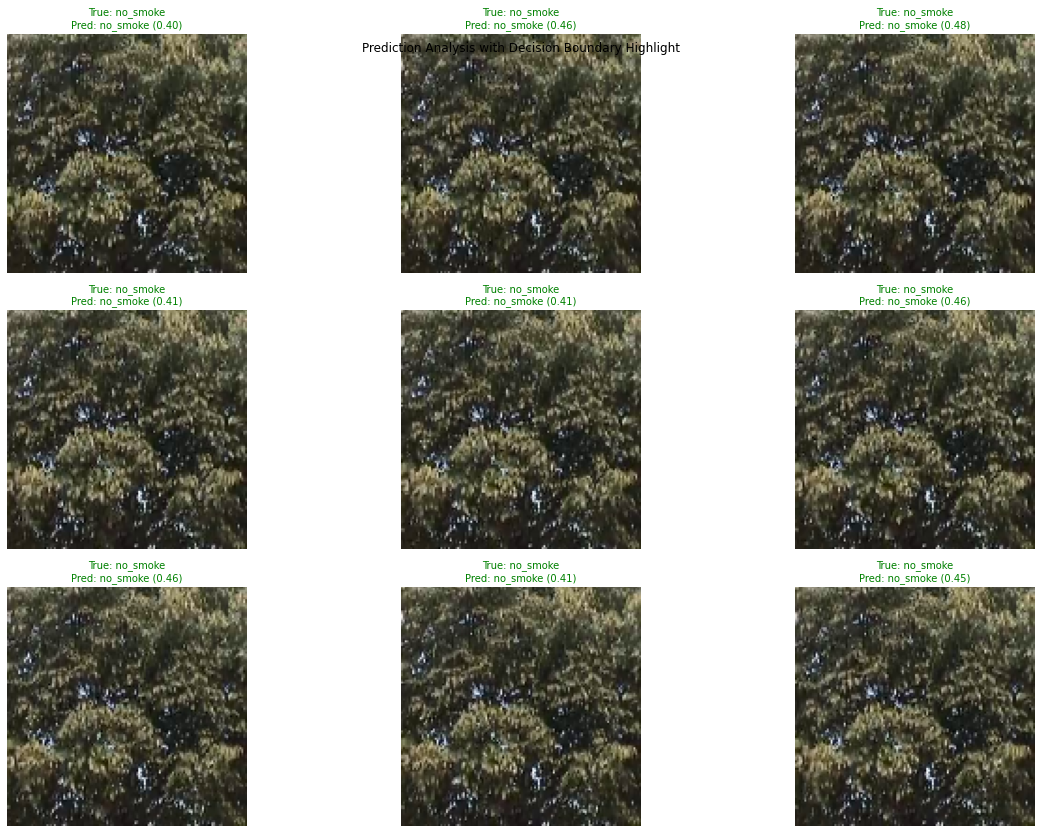

In [7]:
# 修改后的Cell 6（完整替换）
"""
# 增强型预测示例
def enhanced_prediction_analysis(model, test_generator, threshold=0.474):
    # 获取批量数据
    sample_images, sample_labels = next(test_generator)
    predictions = model.predict(sample_images)
    
    # 创建可视化画布
    plt.figure(figsize=(18, 12))
    
    for i in range(9):
        # 原始图像
        plt.subplot(3, 3, i+1)
        plt.imshow(sample_images[i])
        true_label = 'smoke' if sample_labels[i]==1 else 'no_smoke'
        pred_prob = predictions[i][0]
        pred_label = 'smoke' if pred_prob > threshold else 'no_smoke'
        color = 'green' if true_label == pred_label else 'red'
        
        # 添加标注
        plt.title(f"True: {true_label}\nPred: {pred_label} ({pred_prob:.2f})", 
                 color=color, fontsize=10)
        plt.axis('off')
    
    plt.suptitle("Prediction Analysis with Decision Boundary Highlight", y=0.92)
    plt.tight_layout()
    plt.show()
    
    # 添加阈值附近样本分析
    threshold_range = 0.05
    near_threshold = np.where(np.abs(predictions - threshold) < threshold_range)[0]
    
    if len(near_threshold) > 0:
        print(f"\n发现{len(near_threshold)}个阈值附近样本（{threshold-threshold_range:.2f}~{threshold+threshold_range:.2f}）")
        plt.figure(figsize=(12, 6))
        for j, idx in enumerate(near_threshold[:3]):
            plt.subplot(1, 3, j+1)
            plt.imshow(sample_images[idx])
            true_label = 'smoke' if sample_labels[idx]==1 else 'no_smoke'
            plt.title(f"ID:{idx}\nTrue:{true_label}\nProb:{predictions[idx][0]:.2f}")
            plt.axis('off')
        plt.suptitle("Threshold Borderline Cases Analysis", y=0.95)
        plt.show()

# 执行分析
enhanced_prediction_analysis(model, test_generator, best_threshold)
"""
# Cell 6 完整代码（修改后的）
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import os
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# 增强型预测示例
def enhanced_prediction_analysis(model, test_generator, threshold=0.474):
    # 获取批量数据
    sample_images, sample_labels = next(test_generator)
    predictions = model.predict(sample_images)
    
    # 创建可视化画布
    plt.figure(figsize=(18, 12))
    
    for i in range(9):
        # 原始图像
        plt.subplot(3, 3, i+1)
        plt.imshow(sample_images[i])
        true_label = 'smoke' if sample_labels[i]==1 else 'no_smoke'
        pred_prob = predictions[i][0]
        pred_label = 'smoke' if pred_prob > threshold else 'no_smoke'
        color = 'green' if true_label == pred_label else 'red'
        
        # 添加标注
        plt.title(f"True: {true_label}\nPred: {pred_label} ({pred_prob:.2f})", 
                 color=color, fontsize=10)
        plt.axis('off')
    
    plt.suptitle("Prediction Analysis with Decision Boundary Highlight", y=0.92)
    plt.tight_layout()
    plt.show()
    
    # 添加阈值附近样本分析
    threshold_range = 0.05
    near_threshold = np.where(np.abs(predictions - threshold) < threshold_range)[0]
    
    if len(near_threshold) > 0:
        print(f"\n发现{len(near_threshold)}个阈值附近样本（{threshold-threshold_range:.2f}~{threshold+threshold_range:.2f}）")
        plt.figure(figsize=(12, 6))
        for j, idx in enumerate(near_threshold[:3]):
            plt.subplot(1, 3, j+1)
            plt.imshow(sample_images[idx])
            true_label = 'smoke' if sample_labels[idx]==1 else 'no_smoke'
            plt.title(f"ID:{idx}\nTrue:{true_label}\nProb:{predictions[idx][0]:.2f}")
            plt.axis('off')
        plt.suptitle("Threshold Borderline Cases Analysis", y=0.95)
        plt.show()

# 执行分析
enhanced_prediction_analysis(model, test_generator, best_threshold)
